In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn') # to plot graphs in seaborn style

In [2]:
# importing labelled train data as data to avoid confusion with term 'train during the model building process'
data = pd.read_csv('data/train_s3TEQDk.csv')

# naming test data as new_cust to avoid confusion in name data
new_cust = pd.read_csv('data/test_mSzZ8RL.csv')

In [3]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## EDA

In [104]:
#creating copy of data for preprocessing 
df  = data.copy()

In [5]:
df['avg_account_bal_in_million'] = df.Avg_Account_Balance/1000000

In [3]:
# extracting numeric and categorical column to underdstand data better 
num_cols = ['Age','Vintage' , 'Avg_Account_Balance']  
cat_cols = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active','Is_Lead']

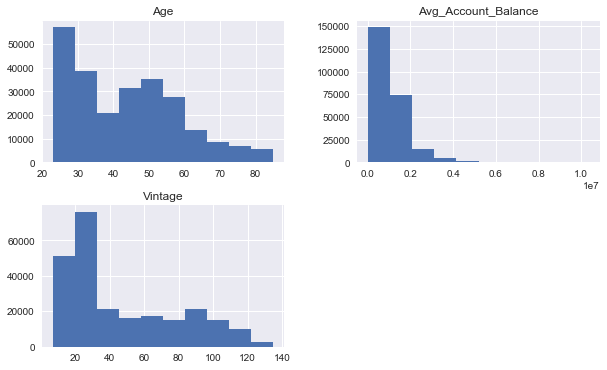

In [7]:
df.hist(column=num_cols, figsize=(10,6));

#### insights 
1. There are many customers belongs to age group between 20-30 , hence we should check if customer's age group could be a better indicator for the required prediction
2. avg account balance is skewed , hence take log tranformation of avg_account_balance
3. check relation of categories of vintage with target variable whether it less vintage month has any effect on customer becoming a Lead.

#### Avg Account Balance

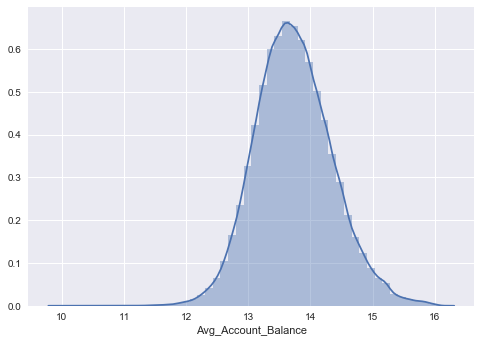

In [8]:
# plotting log of Avg_Account_Balance
sns.distplot(np.log(df.Avg_Account_Balance));

In [12]:
# build a function to transform selected columns into log
def log_transform(X,column_list, remove_original = False):
    '''
    either single column of list of columns could be given
    to apply log transformation 
    '''
    for col in column_list:
        if remove_original:                 # replace original column values with it log
            X[col] = np.log(X[col])
        
        else:
            X[col+'_log'] = np.log(X[col])  # create new variable with log values of columns
    
    return X


# applying it into dataframe
df = log_transform(df,column_list=['Avg_Account_Balance'], remove_original=False)

#### Age

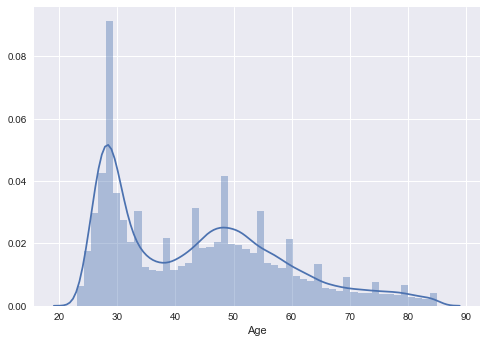

In [106]:
sns.distplot((df.Age));

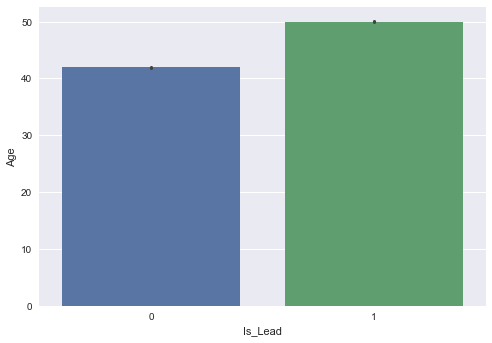

In [10]:
# age has impact on becoming a lead
sns.barplot(df.Is_Lead ,df.Age );

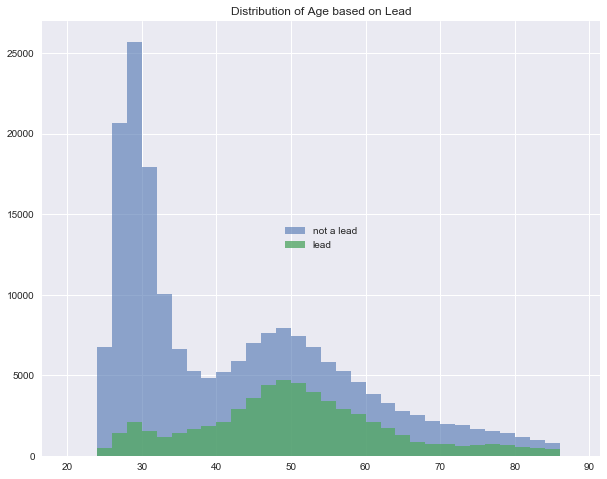

In [11]:
plt.figure(figsize = (10,8))
plt.title('Distribution of Age based on Lead')
plt.hist(df.Age[df.Is_Lead == 0],alpha=0.6,bins=np.arange(20,90,2), label = 'not a lead');  
plt.hist(df.Age[df.Is_Lead == 1],alpha=0.8,bins=np.arange(20,90,2), label = 'lead');
plt.legend(loc ='center');

In [108]:
df['Age_group'] = pd.cut(df.Age , bins = np.arange(20,100,10),right =True)

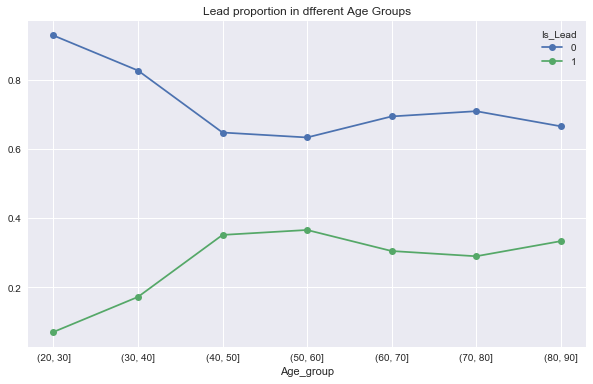

In [51]:
pd.crosstab(df.Age_group, df.Is_Lead , normalize='index').plot(kind ='line',figsize = (10,6),
                                                               title = "Lead proportion in dfferent Age Groups",marker='o');
plt.xticks(np.arange(7),[i.strip() for i in '(20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80] < (80, 90]'.split('<')]);

      Customer belonging to age category  less than 40 has fewer chances of becoming a lead.
      
  > Hence, using age-categories instead of Age could be a better option 

#### Vintage

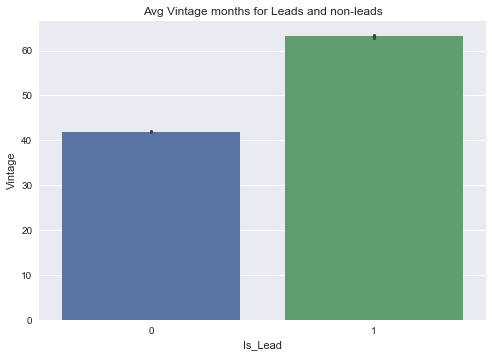

In [14]:

plt.title('Avg Vintage months for Leads and non-leads')
sns.barplot(df.Is_Lead ,df.Vintage );

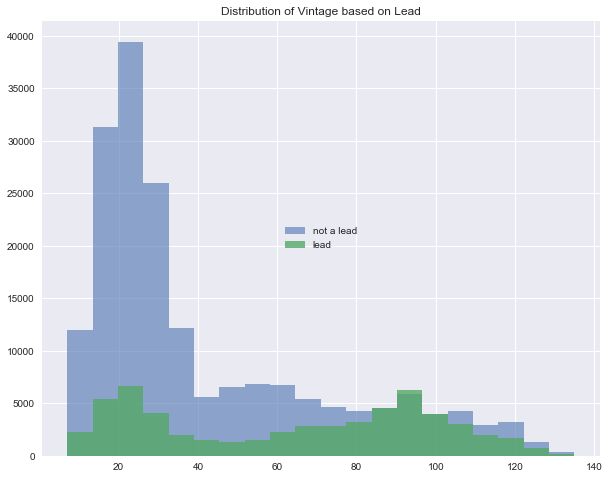

In [15]:
plt.figure(figsize = (10,8))
plt.title('Distribution of Vintage based on Lead')
plt.hist(df.Vintage[df.Is_Lead == 0],alpha=0.6, label = 'not a lead', bins=20);  
plt.hist(df.Vintage[df.Is_Lead == 1],alpha=0.8, label = 'lead', bins=20);
plt.legend(loc ='center');

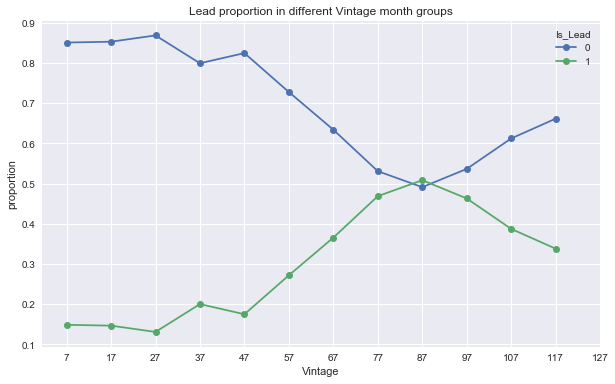

In [58]:
pd.crosstab(pd.cut(df.Vintage, bins=np.arange(7,135,10) ), df.Is_Lead , normalize='index').plot(kind ='line',figsize = (10,6),
                                                               title = "Lead proportion in different Vintage month groups",marker = 'o'
                                                                                        )
plt.xticks(np.arange(13),[  7,  17,  27,  37,  47,  57,  67,  77,  87,  97, 107, 117, 127])
plt.ylabel("proportion");

##### missing values

In [143]:
def detect_missing_columns(DF):
    output = {'col':[],'type':[],'n_miss':[],'perc_miss':[]}
    n = 0
    for col in DF.columns:                       #iterate every column
        #find which column has NA present
        na = df[col].isna().sum()
        if na>0:                                      # if NA found append the dictionary with required info
            output['col'].append(col)                 # add col name
            output['type'].append(DF[col].dtype)      # dtype of column to help imputation strategy 
            output['n_miss'].append(na)               # no of NAs
            output['perc_miss'].append(f"{round(na/len(DF)*100,2)}%")    # get perc of missings in the column
            n +=1
    print(f"Missing values found in {n} column/s")
    return pd.DataFrame(output)

In [144]:
detect_missing_columns(df)

Missing values found in 1 column/s


,col,type,n_miss,perc_miss
0,Credit_Product,object,29325,11.93%


 > we cannot remove 12% observations from the data , dropping the whole column would be not be a best solution as it  Credit_Product might play important role in classifying among leads.
 
 > lets analyse the column behaviour with the target variable

#### Credit Product

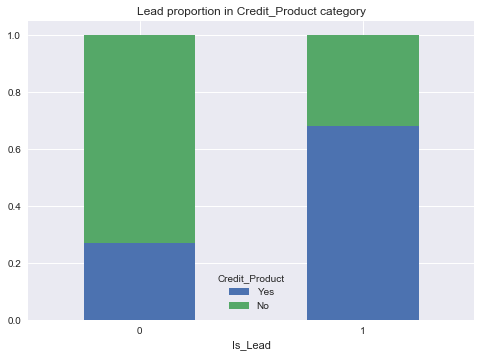

In [175]:
pd.crosstab(df.Is_Lead,df.Credit_Product, normalize ='index').iloc[:,[-1,-2]].plot(kind='bar',
                                                                                               title = 'Lead proportion in Credit_Product category', 
                                                                                               stacked =True,rot =0);

In [143]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Avg_Account_Balance_log,Age_group
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0,13.860193,"(70, 80]"
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0,13.274205,"(20, 30]"
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0,14.210464,"(50, 60]"
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0,13.061453,"(30, 40]"
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0,13.695360,"(20, 30]"


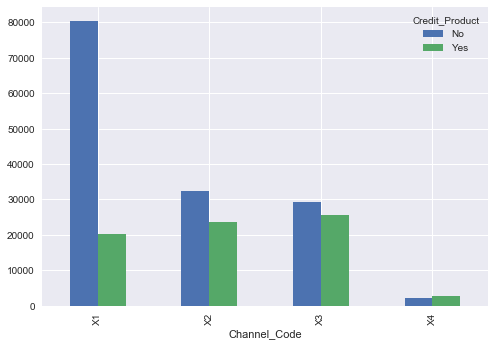

In [223]:
pd.crosstab(df.Channel_Code,df.Credit_Product).plot(kind='bar');

           chances of becoming a lead rises from 30% to 70% when Credit Product is 'yes'
           
 > Hence we should impute NA with most frequent category of credit product 

#### categorical data understanding 

In [227]:
print(cat_cols)

['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', 'Is_Lead']


In [228]:
# summary
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(),x.nunique(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0,1],
                     round((Mode.iloc[0,1]*100)/x.count(), 2)],
                     index = ['N','N_uniq','NMiss', 'Mode', 'Mod_Freq', 'Mod_Percent'])

df[cat_cols].apply(categorical_var_summary)

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active,Is_Lead
N,245725,245725,245725,245725,216400,245725,245725.00
N_uniq,2,35,4,4,2,2,2.00
NMiss,0,0,0,0,29325,0,0.00
Mode,Male,RG268,Self_Employed,X1,No,No,0.00
Mod_Freq,134197,35934,100886,103718,144357,150290,187437.00
Mod_Percent,54.61,14.62,41.06,42.21,66.71,61.16,76.28


 > taget variable Is_Lead has only 24% true value , hence imbalanced data


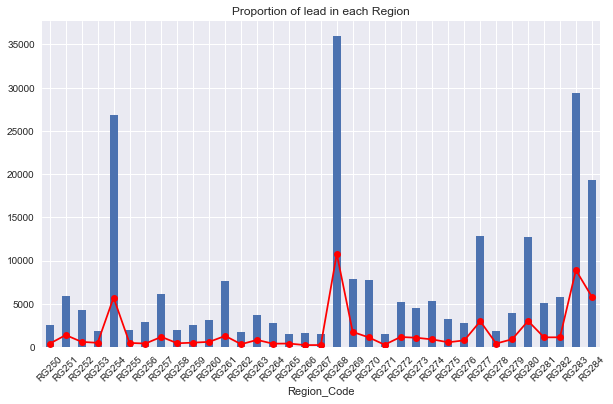

In [225]:
df.Region_Code.value_counts().sort_index().plot(kind='bar', figsize=(10,6), title='Proportion of lead in each Region' , rot=45);
pd.crosstab(df.Region_Code,df.Is_Lead).iloc[:,1].sort_index().plot(c='r', marker='o', rot=45);

#### Building preprocessing function
        Following are some custom function based on the insights of EDA performed above

In [5]:
# select dataframe
from sklearn.base import BaseEstimator, TransformerMixin
class Select_dataframe(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.loc[:,self.columns]

In [6]:
## mode imputer for categorical missing value imputation

class Mode_imputer(BaseEstimator, TransformerMixin):      
    def fit(self,X ,y=None):
        self.mode_list =pd.Series( [X[col].mode()[0] for col in X] ,index=X.columns  )
        return self
    
    def transform(self,X,y=None):
        return X.fillna(self.mode_list)

In [7]:
### age-bins
def Age_to_bins(X,bins, remove_original = False):
    bins = pd.Series(pd.cut(X['Age'], bins=bins), index=X.index)
    if remove_original:
        X['Age'] = bins
        return X
    else:
        return bins

In [8]:
class Outlier_Capping(BaseEstimator, TransformerMixin):      
    def fit(self,X ,y=None):
        self.lower_list =pd.Series( [X[col].quantile(0.01) for col in X] ,index=X.columns  )
        self.upper_list =pd.Series( [X[col].quantile(0.99) for col in X] ,index=X.columns  )
        return self
    
    def transform(self,X,y=None):
        return X.clip(self.lower_list, self.upper_list ,axis=1)

#### build pipelines

In [9]:
from sklearn.pipeline import Pipeline ,FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer

In [13]:
num_pipe = Pipeline([ ('selector' , Select_dataframe(num_cols)),
                     ('log_tranformer',FunctionTransformer(log_transform ,kw_args ={'column_list' : ['Avg_Account_Balance'],
                                                                                  'remove_original':True})),
                     ('outlier_removals', Outlier_Capping()),
                   ('imputer', SimpleImputer(strategy ='median')),
                   ('scalar',StandardScaler())
                   ])

In [14]:
# removing target from cat features
cat_cols.remove('Is_Lead')
# segrefating binary cols from all categorical cols
binary_attribs = ['Gender','Credit_Product', 'Is_Active']
multi_cat_attribs = ['Region_Code', 'Occupation', 'Channel_Code']

In [15]:
multi_cat_pipe = Pipeline([('selector' , Select_dataframe(multi_cat_attribs)),
                     ('imputer', Mode_imputer()), 
                     ('encoder', OneHotEncoder(sparse=False))
                    ])

In [16]:
binary_cat_pipe = Pipeline([('selector' , Select_dataframe(binary_attribs)),
                      ('imputer', Mode_imputer()), 
                     ('binarizer', OneHotEncoder(drop='first', sparse=False))
                    ])

In [17]:
# combine all pipelines
full_preprocess_pipe = FeatureUnion([('num_pipe_', num_pipe),
                                     ('multi_cat_pipe_', multi_cat_pipe),
                                     ('binary_cat_pipe_', binary_cat_pipe)
                             
                              ])

#### data preparation

In [18]:
from sklearn.model_selection import train_test_split
# split data into train n test to check model performance
train, test =  train_test_split(data, test_size= 0.2, random_state = 42)

In [19]:
# fit transform X_train by pipeline
X_train  = full_preprocess_pipe.fit_transform(train)
y_train = train['Is_Lead'].values

In [20]:
# transforming test data
X_test= full_preprocess_pipe.transform(test)
y_test = test['Is_Lead'].values

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196580, 49), (49145, 49), (196580,), (49145,))

In [324]:
# saving prepared dataset
#pd.DataFrame(X_train).to_csv('X_train.csv')
#pd.DataFrame(X_test).to_csv('X_test.csv')
#pd.DataFrame(y_train).to_csv('y_train.csv')
#pd.DataFrame(y_test).to_csv('y_test.csv')

## Model Building

###### simple classification
         Lets check the model performance by checking cross_val_score on simple classification algorithm like SGDClassifier

In [15]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn import metrics

In [99]:
## check model training score by cross validation
np.mean(cross_val_score(LogisticRegression(),X_train,y_train , cv=5, scoring ='roc_auc' ))

0.732610237748342

#### comparing training performance with different algorithms on default parameters

In [17]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [18]:
# Random Forest
np.mean(cross_val_score(RandomForestClassifier(),X_train,y_train , cv=5, scoring ='roc_auc' ))

0.7071929334645753

In [ ]:
# Gradient Boost
np.mean(cross_val_score(GradientBoostingClassifier(),X_train,y_train , cv=5, scoring ='roc_auc' ))

In [21]:
# Gradient Boost
np.mean(cross_val_score(XGBClassifier(),X_train,y_train , cv=5, scoring ='roc_auc' ))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7355469291468181

In [75]:
### Using Gradient Boost to build a final model
gbm = GradientBoostingClassifier()
gbm.fit(X_train,y_train)

GradientBoostingClassifier()

In [47]:
np.mean(cross_val_score(gbm,X_train,y_train , cv=5, scoring ='roc_auc' ))

0.7831640632912829

In [76]:
y_test_pred = gbm.predict(X_test)

In [77]:
# predict resssult on test data
metrics.accuracy_score(y_test,y_test_pred)

0.7915556007732221

In [78]:
print(metrics.classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     37520
           1       0.71      0.20      0.32     11625

    accuracy                           0.79     49145
   macro avg       0.75      0.59      0.60     49145
weighted avg       0.78      0.79      0.74     49145



In [79]:
print(metrics.classification_report(y_train,gbm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88    149917
           1       0.71      0.21      0.32     46663

    accuracy                           0.79    196580
   macro avg       0.76      0.59      0.60    196580
weighted avg       0.78      0.79      0.75    196580



In [100]:
# logistics regression
logit =  LogisticRegression()
logit.fit(X_train, y_train)

LogisticRegression()

In [101]:
metrics.roc_auc_score(y_test,logit.predict(X_test))

0.5485120824449182

In [102]:
print(metrics.classification_report(y_test,logit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87     37520
           1       0.64      0.12      0.20     11625

    accuracy                           0.78     49145
   macro avg       0.71      0.55      0.53     49145
weighted avg       0.75      0.78      0.71     49145



### model performance by undersampling

In [22]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler()

In [23]:
X_train_rs, y_train_rs = under.fit_resample(X_train,y_train)

In [312]:
model = GradientBoostingClassifier()

In [313]:
model.fit(X_train_rs,y_train_rs)

GradientBoostingClassifier()

In [314]:
metrics.roc_auc_score(y_train_rs,model.predict(X_train_rs))

0.7182992949446028

In [318]:
metrics.recall_score(y_test,model.predict(X_test))

0.7469247311827957

In [328]:
np.mean(cross_val_score(model, X_train_rs,y_train_rs,scoring = 'roc_auc' , cv =5))

0.7831521834738175

In [331]:
# check other algorithm score on resampled dataset
## logistic regression
np.mean(cross_val_score(LogisticRegression(), X_train_rs,y_train_rs,scoring = 'roc_auc' , cv =5))

0.7331859398762324

In [332]:
## Random Forest
np.mean(cross_val_score(RandomForestClassifier(), X_train_rs,y_train_rs,scoring = 'roc_auc' , cv =5))

0.7578881392537797

In [333]:
## XGboost
np.mean(cross_val_score(XGBClassifier(), X_train_rs,y_train_rs,scoring = 'roc_auc' , cv =5))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7817992609659482

### hyperparameter tuning for best model  -  Gradient Boosting Algorithm

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
pargrid_gbm = {'n_estimators': [200, 400, 600],
                 'max_features' : [20,40]}

In [28]:
gbm_gridsearch = GridSearchCV(GradientBoostingClassifier(learning_rate = 0.1), param_grid =pargrid_gbm,scoring ='roc_auc',
                              verbose= 1 , n_jobs =-1 , cv=3)

In [29]:
gbm_gridsearch.fit(X_train_rs,y_train_rs)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_features': [20, 40],
                         'n_estimators': [200, 400, 600]},
             scoring='roc_auc', verbose=1)

In [30]:
gbm_gridsearch.best_score_

0.7844328032897265

In [31]:
gbm_gridsearch.best_params_

{'max_features': 20, 'n_estimators': 600}

In [32]:
best_model = gbm_gridsearch.best_estimator_

In [34]:
metrics.roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

0.783734475089988

   model is giving similar score for test and train data , hence we can consider it as final model to predict for new customer data

### predict for new data

In [38]:
new_data = new_cust.copy()
new_data['Is_Lead'] =np.nan

In [39]:
 # preprocess new data
new_cust_pipe = full_preprocess_pipe.transform(new_data)

In [41]:
# getting prob score by best model
new_cust_prob = best_model.predict_proba(new_cust_pipe)[:,1]

In [42]:
## saving the desired output
output_df = pd.DataFrame({'ID':new_data.ID ,'Is_Lead':new_cust_prob})
output_df.to_csv('output_resample_gboost_tuned.csv', index=False)